# Validating `specsim`
In this notebook, I want to compare the CMX coadd data to `specsim` output for 
- source flux = `cframe` spectra
- fiber acceptance fraction = GFA transp x fiber fraction
- sky brightness = sky brightness derived from `sky` data

In [1]:
import os 
import fitsio
import numpy as np 
from scipy.signal import medfilt
from scipy.interpolate import interp1d
import astropy.units as u
# --- desihub --- 
import desisim.simexp
import specsim.instrument
from specsim.simulator import Simulator 

from desispec.io import read_frame
from desitarget.cmx import cmx_targetmask
from desimodel.io import load_throughput

In [2]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
wavemin = load_throughput('b').wavemin - 10.0
wavemax = load_throughput('z').wavemax + 10.0
wave = np.arange(round(wavemin, 1), wavemax, 0.8) * u.Angstrom

# Generate specsim config object for a given wavelength grid
config = desisim.simexp._specsim_config_for_wave(wave.to('Angstrom').value, dwave_out=0.8, specsim_config_file='desi')

# CMX data
First lets read `frame`, `sky`, `flux_calib`, `cframe` data for the following exposure
- tile ID = 70502
- date = 20200225
- exp ID = 52113
- spectrograph 0

In [4]:
tileid = 70502
date = 20200225
expid = 52113
ispec = 0 

dir_redux = "/global/cfs/cdirs/desi/spectro/redux/daily" 
dir_coadd = '/global/cfs/cdirs/desi/users/chahah/bgs_exp_coadd/'

In [5]:
f_sky = lambda band: os.path.join(dir_redux, 'exposures', str(date), str(expid).zfill(8), 
                                  'sky-%s%i-%s.fits' % (band, ispec, str(expid).zfill(8)))
f_calib = lambda band: os.path.join(dir_redux, 'exposures', str(date), str(expid).zfill(8), 
                                    'fluxcalib-%s%i-%s.fits' % (band, ispec, str(expid).zfill(8)))
f_frame = lambda band: os.path.join(dir_redux, 'exposures', str(date), str(expid).zfill(8), 
                                     'frame-%s%i-%s.fits' % (band, ispec, str(expid).zfill(8)))
f_cframe = lambda band: os.path.join(dir_redux, 'exposures', str(date), str(expid).zfill(8), 
                                     'cframe-%s%i-%s.fits' % (band, ispec, str(expid).zfill(8)))

wave_b = fitsio.read(f_cframe('b'), ext=3) 
wave_r = fitsio.read(f_cframe('r'), ext=3) 
wave_z = fitsio.read(f_cframe('z'), ext=3) 

sky_b = fitsio.read(f_sky('b'))
sky_r = fitsio.read(f_sky('r'))
sky_z = fitsio.read(f_sky('z'))

calib_b = fitsio.read(f_calib('b'))
calib_r = fitsio.read(f_calib('r'))
calib_z = fitsio.read(f_calib('z'))

In [6]:
# get exposure time from frame data 
frame_b = read_frame(f_frame('b'))
exptime = frame_b.meta['EXPTIME'] 
print('%.fs exposure' % exptime)

900s exposure


In [7]:
# get which are good fibers from coadd file
f_coadd = os.path.join(dir_coadd, 'coadd-%i-%i-%i-%s.fits' % (tileid, date, ispec, str(expid).zfill(8)))
coadd = fitsio.read(f_coadd)

is_good = (coadd['FIBERSTATUS'] == 0)
is_sky  = (coadd['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('SKY')) != 0 
good_sky = is_good & is_sky
print('%i good sky fibers' % np.sum(good_sky))

89 good sky fibers


## Fiber acceptance fraction 
Now lets get the fiber acceptance fraction from the GFA data, compiled by Aaron Miesner. 
David Kirkby showed in [DocDB](https://desi.lbl.gov/DocDB/cgi-bin/private/ShowDocument?docid=5722) that the GFA (TRANSP) x (FFRAC) agrees well with the fiber throughputs for PSF like object.

In [8]:
# read GFA data
fgfa = os.path.join('/global/cfs/cdirs/desi/users/ameisner/GFA/conditions', 'offline_all_guide_ccds_thru_20200315.fits')
gfa = fitsio.read(fgfa)

In [9]:
isexp = (gfa['EXPID'] == 52113)
nearexp = (gfa['MJD'] > 58900) & (gfa['MJD'] < 58910)

(0, 1.1)

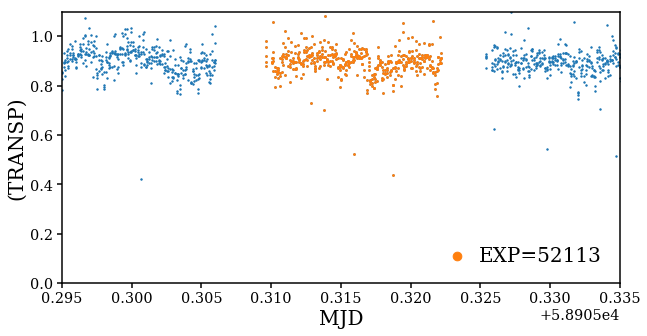

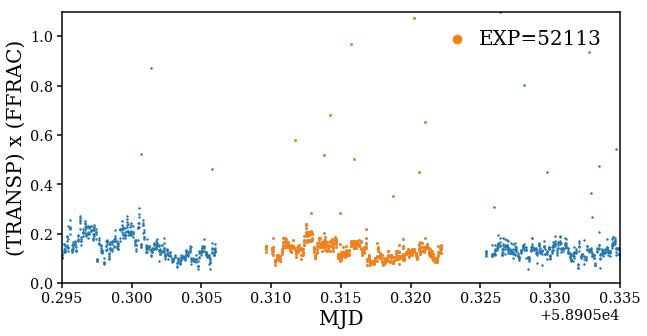

In [10]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)

sub.scatter(gfa['MJD'][nearexp], gfa['TRANSPARENCY'][nearexp], s=2)
sub.scatter(gfa['MJD'][isexp], gfa['TRANSPARENCY'][isexp], s=3, label='EXP=52113')

sub.legend(loc='lower right', fontsize=20, markerscale=5, handletextpad=0.1)
sub.set_xlabel('MJD', fontsize=20)
sub.set_xlim(58905.295, 58905.335)

sub.set_ylabel('(TRANSP)', fontsize=20)
sub.set_ylim(0, 1.1)

fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)

sub.scatter(gfa['MJD'][nearexp], gfa['TRANSPARENCY'][nearexp] * gfa['FIBER_FRACFLUX'][nearexp], s=2)
sub.scatter(gfa['MJD'][isexp], gfa['TRANSPARENCY'][isexp] * gfa['FIBER_FRACFLUX'][isexp], s=3, label='EXP=52113')

sub.legend(loc='upper right', fontsize=20, markerscale=5, handletextpad=0.1)
sub.set_xlabel('MJD', fontsize=20)
sub.set_xlim(58905.295, 58905.335)

sub.set_ylabel('(TRANSP) x (FFRAC)', fontsize=20)
sub.set_ylim(0, 1.1)

In [11]:
transp = gfa['TRANSPARENCY'][isexp]
print('median transparency for exposure = %f' % np.median(transp[~np.isnan(transp)]))

ffrac = gfa['FIBER_FRACFLUX'][isexp]
print('median fiber fraction = %f' % np.median(ffrac[~np.isnan(ffrac)]))

fibloss = transp * ffrac
print('median (TRANSP) x (FFRAC) = %f' % np.median(fibloss[~np.isnan(fibloss)]))

median transparency for exposure = 0.909859
median fiber fraction = 0.134713
median (TRANSP) x (FFRAC) = 0.133253


In [12]:
print('airmass = %f' % np.median(gfa['AIRMASS'][isexp]))

airmass = 1.304497


# Sky Brightness
~~Calculate sky brightness by flux calibrating the `sky` data. This overestimates the sky brightness since it includes fiberloss.~~

$(\mathtt{sky~surface~brightness}) = (\mathtt{sky~electrons})/(\mathtt{throughput})/(\mathtt{instrument~photons~per~bin})/(\mathtt{exp.~time})/(\mathtt{fiber~area})$

where $(\mathtt{sky~electrons})$ is the sky data

In [13]:
instrument = specsim.instrument.initialize(config, True)

In [14]:
wave_sort = np.argsort(np.concatenate([wave_b, wave_r, wave_z]))

wave_sky = np.concatenate([wave_b, wave_r, wave_z])[wave_sort]
sky_electron = np.concatenate([sky_b, sky_r, sky_z], axis=1)[:,wave_sort]

In [15]:
throughput = np.amax([instrument.cameras[0].throughput, instrument.cameras[1].throughput, instrument.cameras[2].throughput], axis=0)

(0.0, 1.0)

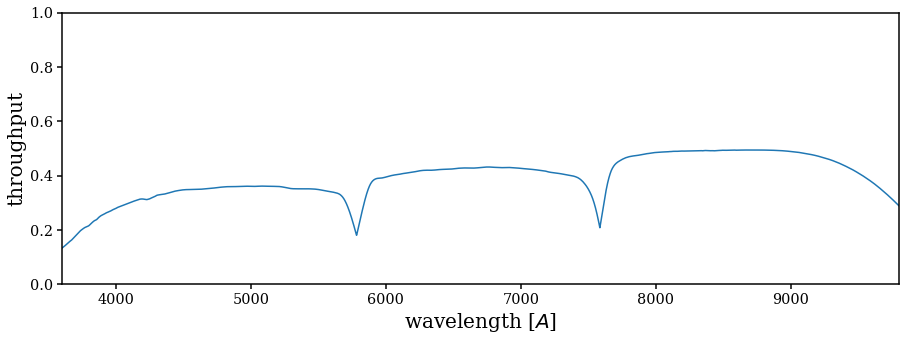

In [16]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
sub.plot(wave, throughput)
sub.set_xlabel('wavelength [$A$]', fontsize=20)
sub.set_xlim(3600, 9800)
sub.set_ylabel('throughput', fontsize=20)
sub.set_ylim(0., 1.)

In [17]:
plate_scale = config.load_table(config.instrument.plate_scale, ['radius', 'radial_scale', 'azimuthal_scale'], interpolate=False)
radial_fiber_size = (0.5 * instrument.fiber_diameter / instrument.radial_scale(plate_scale['radius']))
azimuthal_fiber_size = (0.5 * instrument.fiber_diameter / instrument.azimuthal_scale(plate_scale['radius']))

desi_fiber_area = np.mean(np.pi*radial_fiber_size * azimuthal_fiber_size)

In [18]:
# calculate sky brightness
fsky = interp1d(wave_sky, sky_electron[good_sky,:], fill_value=0., axis=1, bounds_error=False)

sky_flux = fsky(wave) / throughput / instrument.photons_per_bin / exptime * 1e17

sky_bright = sky_flux / desi_fiber_area

/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in true_divide
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide


In [19]:
nominal_surface_brightness_dict = config.load_table(config.atmosphere.sky, 'surface_brightness', as_dict=True)

/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median for 26 results
  r = func(a, **kwargs)


(0.0, 2.0)

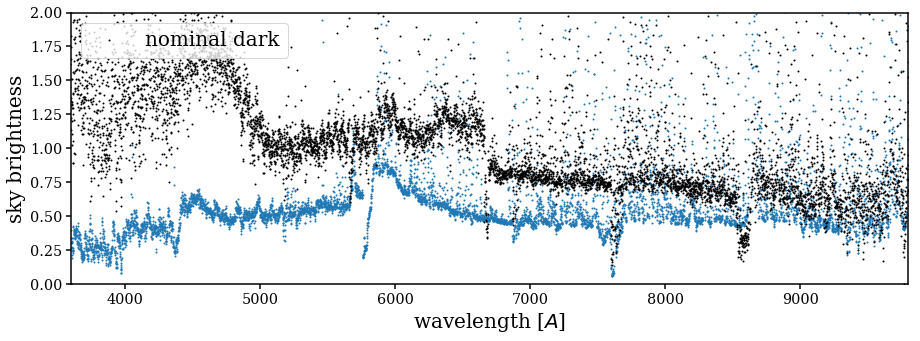

In [20]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)

sub.scatter(wave, np.median(sky_bright, axis=0), c='C0', s=1) 
    
sub.scatter(wave.value, nominal_surface_brightness_dict['dark'].value, c='k', s=1, label='nominal dark')

sub.legend(loc='upper left', frameon=True, fontsize=20)
sub.set_xlabel('wavelength [$A$]', fontsize=20)
sub.set_xlim(3600, 9800)
sub.set_ylabel('sky brightness', fontsize=20)
sub.set_ylim(0., 2.)

# CMX spectra
lets read in `cframe` spectra for a bright $r \sim 16.5$ BGS galaxy. This is *not* the actual source flux of this BGS galaxy! 

In [21]:
# directory with coadds constructed from single exposure cframe data 
dir_coadd = '/global/cfs/cdirs/desi/users/chahah/bgs_exp_coadd/'

In [22]:
fcoadd = os.path.join(dir_coadd, 'coadd-%i-%i-%i-%s.fits' % (tileid, date, ispec, str(expid).zfill(8)))

In [23]:
coadd = fitsio.read(fcoadd)
coadd_wave = fitsio.read(fcoadd, ext=2)
coadd_flux = fitsio.read(fcoadd, ext=3)
coadd_ivar = fitsio.read(fcoadd, ext=4)

In [24]:
is_BGS  = (coadd['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('SV0_BGS')) != 0 
print('%i BGS targets' % np.sum(is_BGS))

288 BGS targets


In [25]:
coadd_rmag =  22.5 - 2.5 * np.log10(coadd['FLUX_R']) 
coadd_gmag =  22.5 - 2.5 * np.log10(coadd['FLUX_G']) 

/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


In [26]:
np.random.seed(0)

In [27]:
gal_cut = is_BGS & (coadd_rmag > 16.4) & (coadd_rmag < 16.6) & (np.sum(coadd_flux, axis=1) != 0)
igal = np.random.choice(np.arange(len(gal_cut))[gal_cut])

In [28]:
print('fiber #%i' % coadd['FIBER'][igal])

fiber #268


(0.0, 40.0)

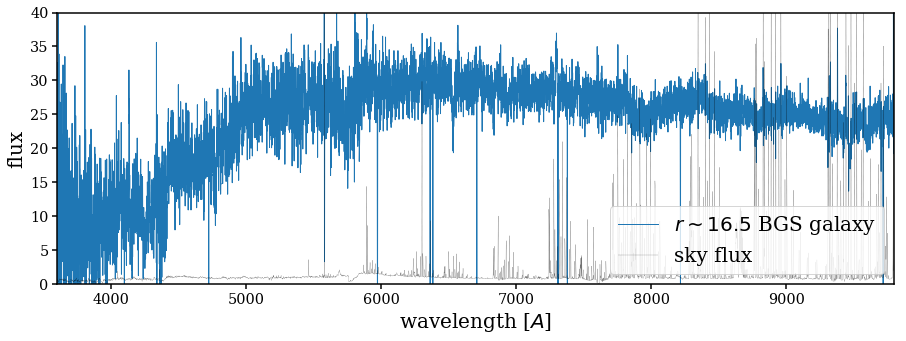

In [29]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)

sub.plot(coadd_wave, coadd_flux[igal,:], c='C0', lw=1, label='$r\sim16.5$ BGS galaxy')

sub.plot(wave, np.median(sky_flux, axis=0), c='k', lw=0.2, ls='--', label='sky flux')

sub.legend(loc='lower right', frameon=True, fontsize=20)
sub.set_xlabel('wavelength [$A$]', fontsize=20)
sub.set_xlim(3600, 9800)
sub.set_ylabel('flux', fontsize=20)
sub.set_ylim(0., 40.)

## comparison to `specsim`
As the input source flux for `specsim`, lets use the smoothed `cframe` spectra. 

In [30]:
desi = Simulator(config, num_fibers=1)

In [31]:
coadd_flux_smooth = np.interp(wave, coadd_wave, medfilt(coadd_flux[igal,:], 101)) * 1e-17 * desi.simulated['source_flux'].unit

(0.0, 40.0)

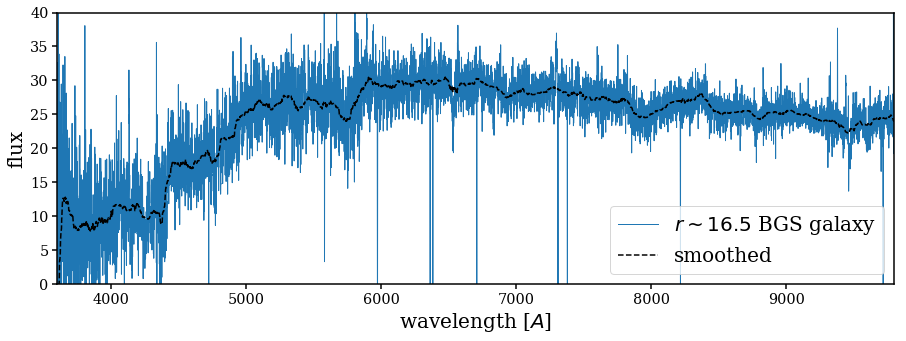

In [32]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)

sub.plot(coadd_wave, coadd_flux[igal,:], c='C0', lw=1, label='$r\sim16.5$ BGS galaxy')
sub.plot(wave, coadd_flux_smooth.value * 1e17, c='k', ls='--', label='smoothed')

sub.legend(loc='lower right', frameon=True, fontsize=20)
sub.set_xlabel('wavelength [$A$]', fontsize=20)
sub.set_xlim(3600, 9800)
sub.set_ylabel('flux', fontsize=20)
sub.set_ylim(0., 40.)

In [33]:
# initialize the exposure time
desi.observation.exposure_time = exptime * u.s
print('%.fs exposure' % desi.observation.exposure_time.to(u.s).value) 

900s exposure


In [34]:
# manually set the surface brightness 
desi.atmosphere._surface_brightness_dict[desi.atmosphere.condition] = np.interp(desi.atmosphere._wavelength, wave, np.median(sky_bright, axis=0)) * desi.atmosphere.surface_brightness.unit
desi.atmosphere._extinct_emission = False
desi.atmosphere._moon = None 
desi.atmosphere.airmass = 1.304497 # high airmass 

/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median for 26 results
  r = func(a, **kwargs)


In [35]:
desi.simulate(source_fluxes=np.atleast_2d(coadd_flux_smooth), fiber_acceptance_fraction=np.tile(0.13325256962932455, np.atleast_2d(coadd_flux_smooth).shape))

In [36]:
random_state = np.random.RandomState(0)
desi.generate_random_noise(random_state, use_poisson=True)

scale=1e17

waves, fluxes, ivars = [], [], []
for table in desi.camera_output :
    print('---------------') 
    print(' wave    ', np.array(table['wavelength'].astype(float)).flatten())
    print(' source  ', np.array(table['num_source_electrons']).flatten())
    print(' sky     ', np.array(table['num_sky_electrons']).flatten())
    print(' dark    ', np.array(table['num_dark_electrons']).flatten())
    print(' read    ', np.array(table['read_noise_electrons']).flatten())

    _wave = table['wavelength'].astype(float)
    _flux = (table['observed_flux']+table['random_noise_electrons']*table['flux_calibration']).T.astype(float)
    _flux = _flux * scale

    _ivar = table['flux_inverse_variance'].T.astype(float)
    _ivar = _ivar / scale**2 

    waves.append(_wave)
    fluxes.append(_flux[0]) 
    ivars.append(_ivar[0])

---------------
 wave     [3569.4 3570.2 3571.  ... 5947.  5947.8 5948.6]
 source   [0.         0.         0.         ... 3.30026682 3.3015922  3.2986943 ]
 sky      [0.         0.         0.         ... 1.96994192 2.08504012 1.95792246]
 dark     [2.39057752 2.39002249 2.38947612 ... 2.67061264 2.67100725 2.67139286]
 read     [7.45625569 7.45539007 7.45453784 ... 7.88088204 7.88146426 7.88203315]
---------------
 wave     [5625.4 5626.2 5627.  ... 7739.  7739.8 7740.6]
 source   [0.67116288 0.69543314 0.7182225  ... 9.25874726 9.13567234 9.02668581]
 sky      [0.31545116 0.3071951  0.28396965 ... 4.10673284 3.28308414 2.97542751]
 dark     [3.18043681 3.17945189 3.17848401 ... 3.77316739 3.77398195 3.77478257]
 read     [5.98606059 5.98513363 5.98422257 ... 6.52004749 6.52075123 6.52144286]
---------------
 wave     [7435.  7435.8 7436.6 ... 9831.8 9832.6 9833.4]
 source   [6.17003995 6.36324706 6.56136845 ... 0.         0.         0.        ]
 sky      [1.65320374 1.62624705 1.66389

(0.0, 40.0)

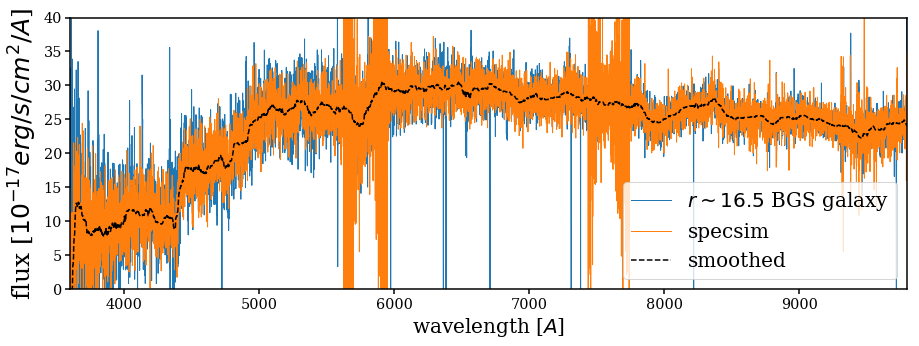

In [37]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)

sub.plot(coadd_wave, coadd_flux[igal,:], c='C0', lw=1, label='$r\sim16.5$ BGS galaxy')
for lbl, _wave, _flux in zip([None, None, 'specsim'], waves, fluxes):
    sub.plot(_wave, _flux, c='C1', lw=1, label=lbl)
sub.plot(wave, coadd_flux_smooth.value * 1e17, c='k', ls='--', label='smoothed')


sub.legend(loc='lower right', frameon=True, fontsize=20)
sub.set_xlabel('wavelength [$A$]', fontsize=20)
sub.set_xlim(3600, 9800)
sub.set_ylabel('flux [$10^{-17} erg/s/cm^2/A$]', fontsize=25) 
sub.set_ylim(0., 40.)

(0.0, 1.0)

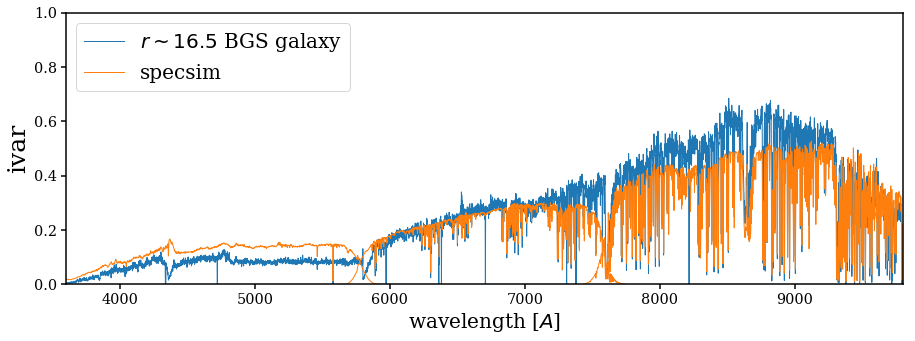

In [38]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)

sub.plot(coadd_wave, coadd_ivar[igal,:], c='C0', lw=1, label='$r\sim16.5$ BGS galaxy')
for lbl, _wave, _ivar in zip([None, None, 'specsim'], waves, ivars):
    sub.plot(_wave, _ivar, c='C1', lw=1, label=lbl)

sub.legend(loc='upper left', frameon=True, fontsize=20)
sub.set_xlabel('wavelength [$A$]', fontsize=20)
sub.set_xlim(3600, 9800)
sub.set_ylabel('ivar', fontsize=25) 
sub.set_ylim(0., 1.)

In [39]:
igal2 = np.random.choice(np.arange(len(gal_cut))[gal_cut])
print('fiber #%i' % coadd['FIBER'][igal2])

fiber #143


---------------
 wave     [3569.4 3570.2 3571.  ... 5947.  5947.8 5948.6]
 source   [0.         0.         0.         ... 1.98844279 1.98632128 1.97973441]
 sky      [0.         0.         0.         ... 1.96994192 2.08504012 1.95792246]
 dark     [2.39057752 2.39002249 2.38947612 ... 2.67061264 2.67100725 2.67139286]
 read     [7.45625569 7.45539007 7.45453784 ... 7.88088204 7.88146426 7.88203315]
---------------
 wave     [5625.4 5626.2 5627.  ... 7739.  7739.8 7740.6]
 source   [0.38617505 0.39875674 0.4113427  ... 5.80305844 5.73549351 5.6729941 ]
 sky      [0.31545116 0.3071951  0.28396965 ... 4.10673284 3.28308414 2.97542751]
 dark     [3.18043681 3.17945189 3.17848401 ... 3.77316739 3.77398195 3.77478257]
 read     [5.98606059 5.98513363 5.98422257 ... 6.52004749 6.52075123 6.52144286]
---------------
 wave     [7435.  7435.8 7436.6 ... 9831.8 9832.6 9833.4]
 source   [ 3.90795092  4.03056613  4.15694669 ... 51.43540156 52.87910356
 54.34281571]
 sky      [1.65320374 1.62624705 

(0.0, 40.0)

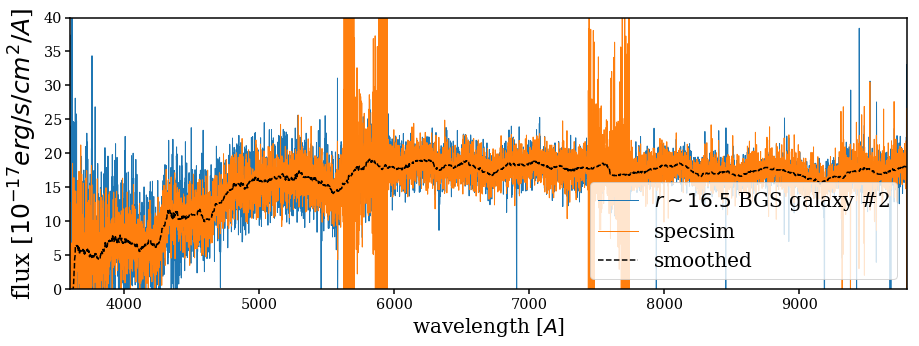

In [40]:
coadd_flux_smooth2 = np.interp(wave, coadd_wave, medfilt(coadd_flux[igal2,:], 101)) * 1e-17 * desi.simulated['source_flux'].unit
desi.simulate(source_fluxes=np.atleast_2d(coadd_flux_smooth2), fiber_acceptance_fraction=np.tile(0.13325256962932455, np.atleast_2d(coadd_flux_smooth).shape))

desi.generate_random_noise(random_state, use_poisson=True)

scale=1e17

waves, fluxes, ivars = [], [], []
for table in desi.camera_output :
    print('---------------') 
    print(' wave    ', np.array(table['wavelength'].astype(float)).flatten())
    print(' source  ', np.array(table['num_source_electrons']).flatten())
    print(' sky     ', np.array(table['num_sky_electrons']).flatten())
    print(' dark    ', np.array(table['num_dark_electrons']).flatten())
    print(' read    ', np.array(table['read_noise_electrons']).flatten())

    _wave = table['wavelength'].astype(float)
    _flux = (table['observed_flux']+table['random_noise_electrons']*table['flux_calibration']).T.astype(float)
    _flux = _flux * scale

    _ivar = table['flux_inverse_variance'].T.astype(float)
    _ivar = _ivar / scale**2 

    waves.append(_wave)
    fluxes.append(_flux[0]) 
    ivars.append(_ivar[0])
    
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)

sub.plot(coadd_wave, coadd_flux[igal2,:], c='C0', lw=1, label='$r\sim16.5$ BGS galaxy #2')
for lbl, _wave, _flux in zip([None, None, 'specsim'], waves, fluxes):
    sub.plot(_wave, _flux, c='C1', lw=1, label=lbl)
sub.plot(wave, coadd_flux_smooth2.value * 1e17, c='k', ls='--', label='smoothed')


sub.legend(loc='lower right', frameon=True, fontsize=20)
sub.set_xlabel('wavelength [$A$]', fontsize=20)
sub.set_xlim(3600, 9800)
sub.set_ylabel('flux [$10^{-17} erg/s/cm^2/A$]', fontsize=25) 
sub.set_ylim(0., 40.)

Text(0,0.5,'ivar')

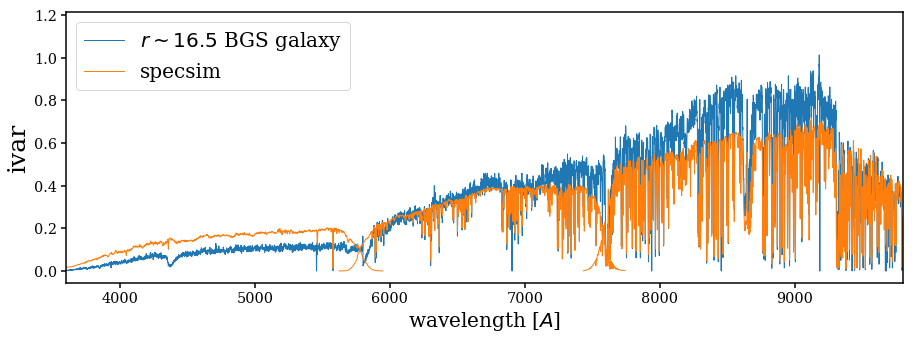

In [41]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)

sub.plot(coadd_wave, coadd_ivar[igal2,:], c='C0', lw=1, label='$r\sim16.5$ BGS galaxy')
for lbl, _wave, _ivar in zip([None, None, 'specsim'], waves, ivars):
    sub.plot(_wave, _ivar, c='C1', lw=1, label=lbl)

sub.legend(loc='upper left', frameon=True, fontsize=20)
sub.set_xlabel('wavelength [$A$]', fontsize=20)
sub.set_xlim(3600, 9800)
sub.set_ylabel('ivar', fontsize=25) 
#sub.set_ylim(0., 30.)

`specsim` output is very close to the data in the $b$ spectrograph. However, `specsim` overestimates the noise in the $r$ and $z$ spectrographs. 